# This notebook shows how to visualize mutational steps and to get sequences with additional mutations.
#### It uses the synthetic sequences file generated via FLY_KC_EFS notebook.
#### It consists of:
* Printing DNA sequences in nucleotide letters for different mutational steps.
* Applying mutations to selected position and substation.
* Plotting the findings.
#### Figures are saved to ./figures/mutational_steps and ./figures/rescue folders

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading DeepFlyBrain data to be used for the initialization of shap.DeepExplainer


In [2]:
print('Loading data...')
f = open('./data/deepflybrain/DeepFlyBrain_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

Loading data...


### Loading the model and initializing shap.DeepExplainer


In [3]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "DeepFlyBrain"
model_json_file = "models/deepflybrain/model.json"
model_hdf5_file = "models/deepflybrain/model_epoch_83.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), nonAugmented_data_dict["train_data"][rn])


Loading model...


In [4]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Loading the generated sequences via in silico evolution

In [5]:
import pickle
f = open("data/deepflybrain/FLY_KC_EFS_6000_withmut.pkl", "rb")
evolved_seq_6000_dict = pickle.load(f)
f.close()

### Plotting prediction scores at different mutational steps

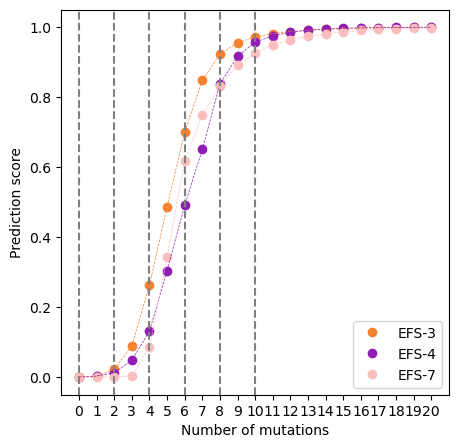

In [24]:
colors_ = ['#e6194b', '#3cb44b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#fabebe', '#008080', '#e6beff', '#9a6324','#800000', '#000075']

plt.figure(figsize=(5,5))
class_no = 35 - 1
ids__ = [[32,'3'],[35,'4'],[91,'7']]
for k,i in enumerate(ids__):
    _ = plt.plot(evolved_seq_6000_dict["mut_pred"][i[0],:21,class_no].T,label="EFS-"+i[1],linestyle="",marker="o",color=colors_[int(i[1])])
plt.legend()
for k,i in enumerate(ids__):
    _ = plt.plot(evolved_seq_6000_dict["mut_pred"][i[0],:21,class_no].T,label="EFS-"+i[1],linestyle="--",linewidth=0.5,color=colors_[int(i[1])])
_ = plt.xticks(range(21),list(range(21)))

for i in range(0,11,2):
    plt.axvline(x=i,linestyle="--",color="gray")
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.savefig("figures/mutational_steps/KC_EFS_3_4_7_Steps_Prediction.pdf",transparent=True)

### Printing nucleotide sequences of evolved enhancers at different mutational steps

In [44]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
for id_ in [32,35,91]:     
    start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
    print("")
    print("id:",id_)
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:10]):
        if i in [0,2,4,6,8]:
            print(i) 
            for nuc in start_x[0]:
                if nuc[0]==1:
                    print("A",end="")
                if nuc[1]==1:
                    print("C",end="")
                if nuc[2]==1:
                    print("G",end="")
                if nuc[3]==1:
                    print("T",end="")
            print("")
        if i <8:
            print(mut_,end=",")
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')


id: 32
0
ACCGAAAAATCAGTAGCTTTTGTTATGGGCCACGTATAGAAAGTTCTAGTGGACCGAATCTAATGTTTGATCCGGGTGTTAATAGTAGACATGTGTGACGGCATAGCTTCGTGCTGTAATGCAAGAGGACTTATATGTTGGCTTAGGTGTTACGCTGGATTCCACTTCTACTCTGGTTGCTTATATTTAGGAATGAGGACGGGAGATTCCCGCGTCTTTAAGTTGCGACACGTTGGTGAAGCTTTTGGGTCGGACGGGACGATCGTAGGGAACCTTGCGACTCCTACAGCCAGTTCGCTCTTGTTTTACTACTTTCCTCGATAACGAATGCGTATATATGTCATATAGAAGCATCCCCTGGTCTAAGTTCTTGAATCCAACCGGCCGCAGACTTAGATGTCGGCTTGCACTTGAATATGGCAATTTATTCCAACCAGGATACCATGTCAGCCTTAAATCAAAACCGTATGTCTAGGGTTAATATTCCGATGACGTAAATT
263_G,216_A,2
ACCGAAAAATCAGTAGCTTTTGTTATGGGCCACGTATAGAAAGTTCTAGTGGACCGAATCTAATGTTTGATCCGGGTGTTAATAGTAGACATGTGTGACGGCATAGCTTCGTGCTGTAATGCAAGAGGACTTATATGTTGGCTTAGGTGTTACGCTGGATTCCACTTCTACTCTGGTTGCTTATATTTAGGAATGAGGACGGGAGATTCCCGCGTCATTAAGTTGCGACACGTTGGTGAAGCTTTTGGGTCGGACGGGACGATGGTAGGGAACCTTGCGACTCCTACAGCCAGTTCGCTCTTGTTTTACTACTTTCCTCGATAACGAATGCGTATATATGTCATATAGAAGCATCCCCTGGTCTAAGTTCTTGAATCCAACCGGCCGCAGACTTAGATGTCGGCTTGCACTTGAATATGGCAATTTATTCCAACCAGGATACCATGTCAGCCTTAAATCAAAACCGTATGTCTAG

### Plotting nucleotide contribution scores for different mutational steps

0,1,0,1,2,3,0,1,2,3,4,5,0,1,2,3,4,5,6,7,0,1,2,3,4,5,6,7,8,9,0,1,0,1,2,3,0,1,2,3,4,5,0,1,2,3,4,5,6,7,0,1,2,3,4,5,6,7,8,9,0,1,0,1,2,3,0,1,2,3,4,5,0,1,2,3,4,5,6,7,0,1,2,3,4,5,6,7,8,9,

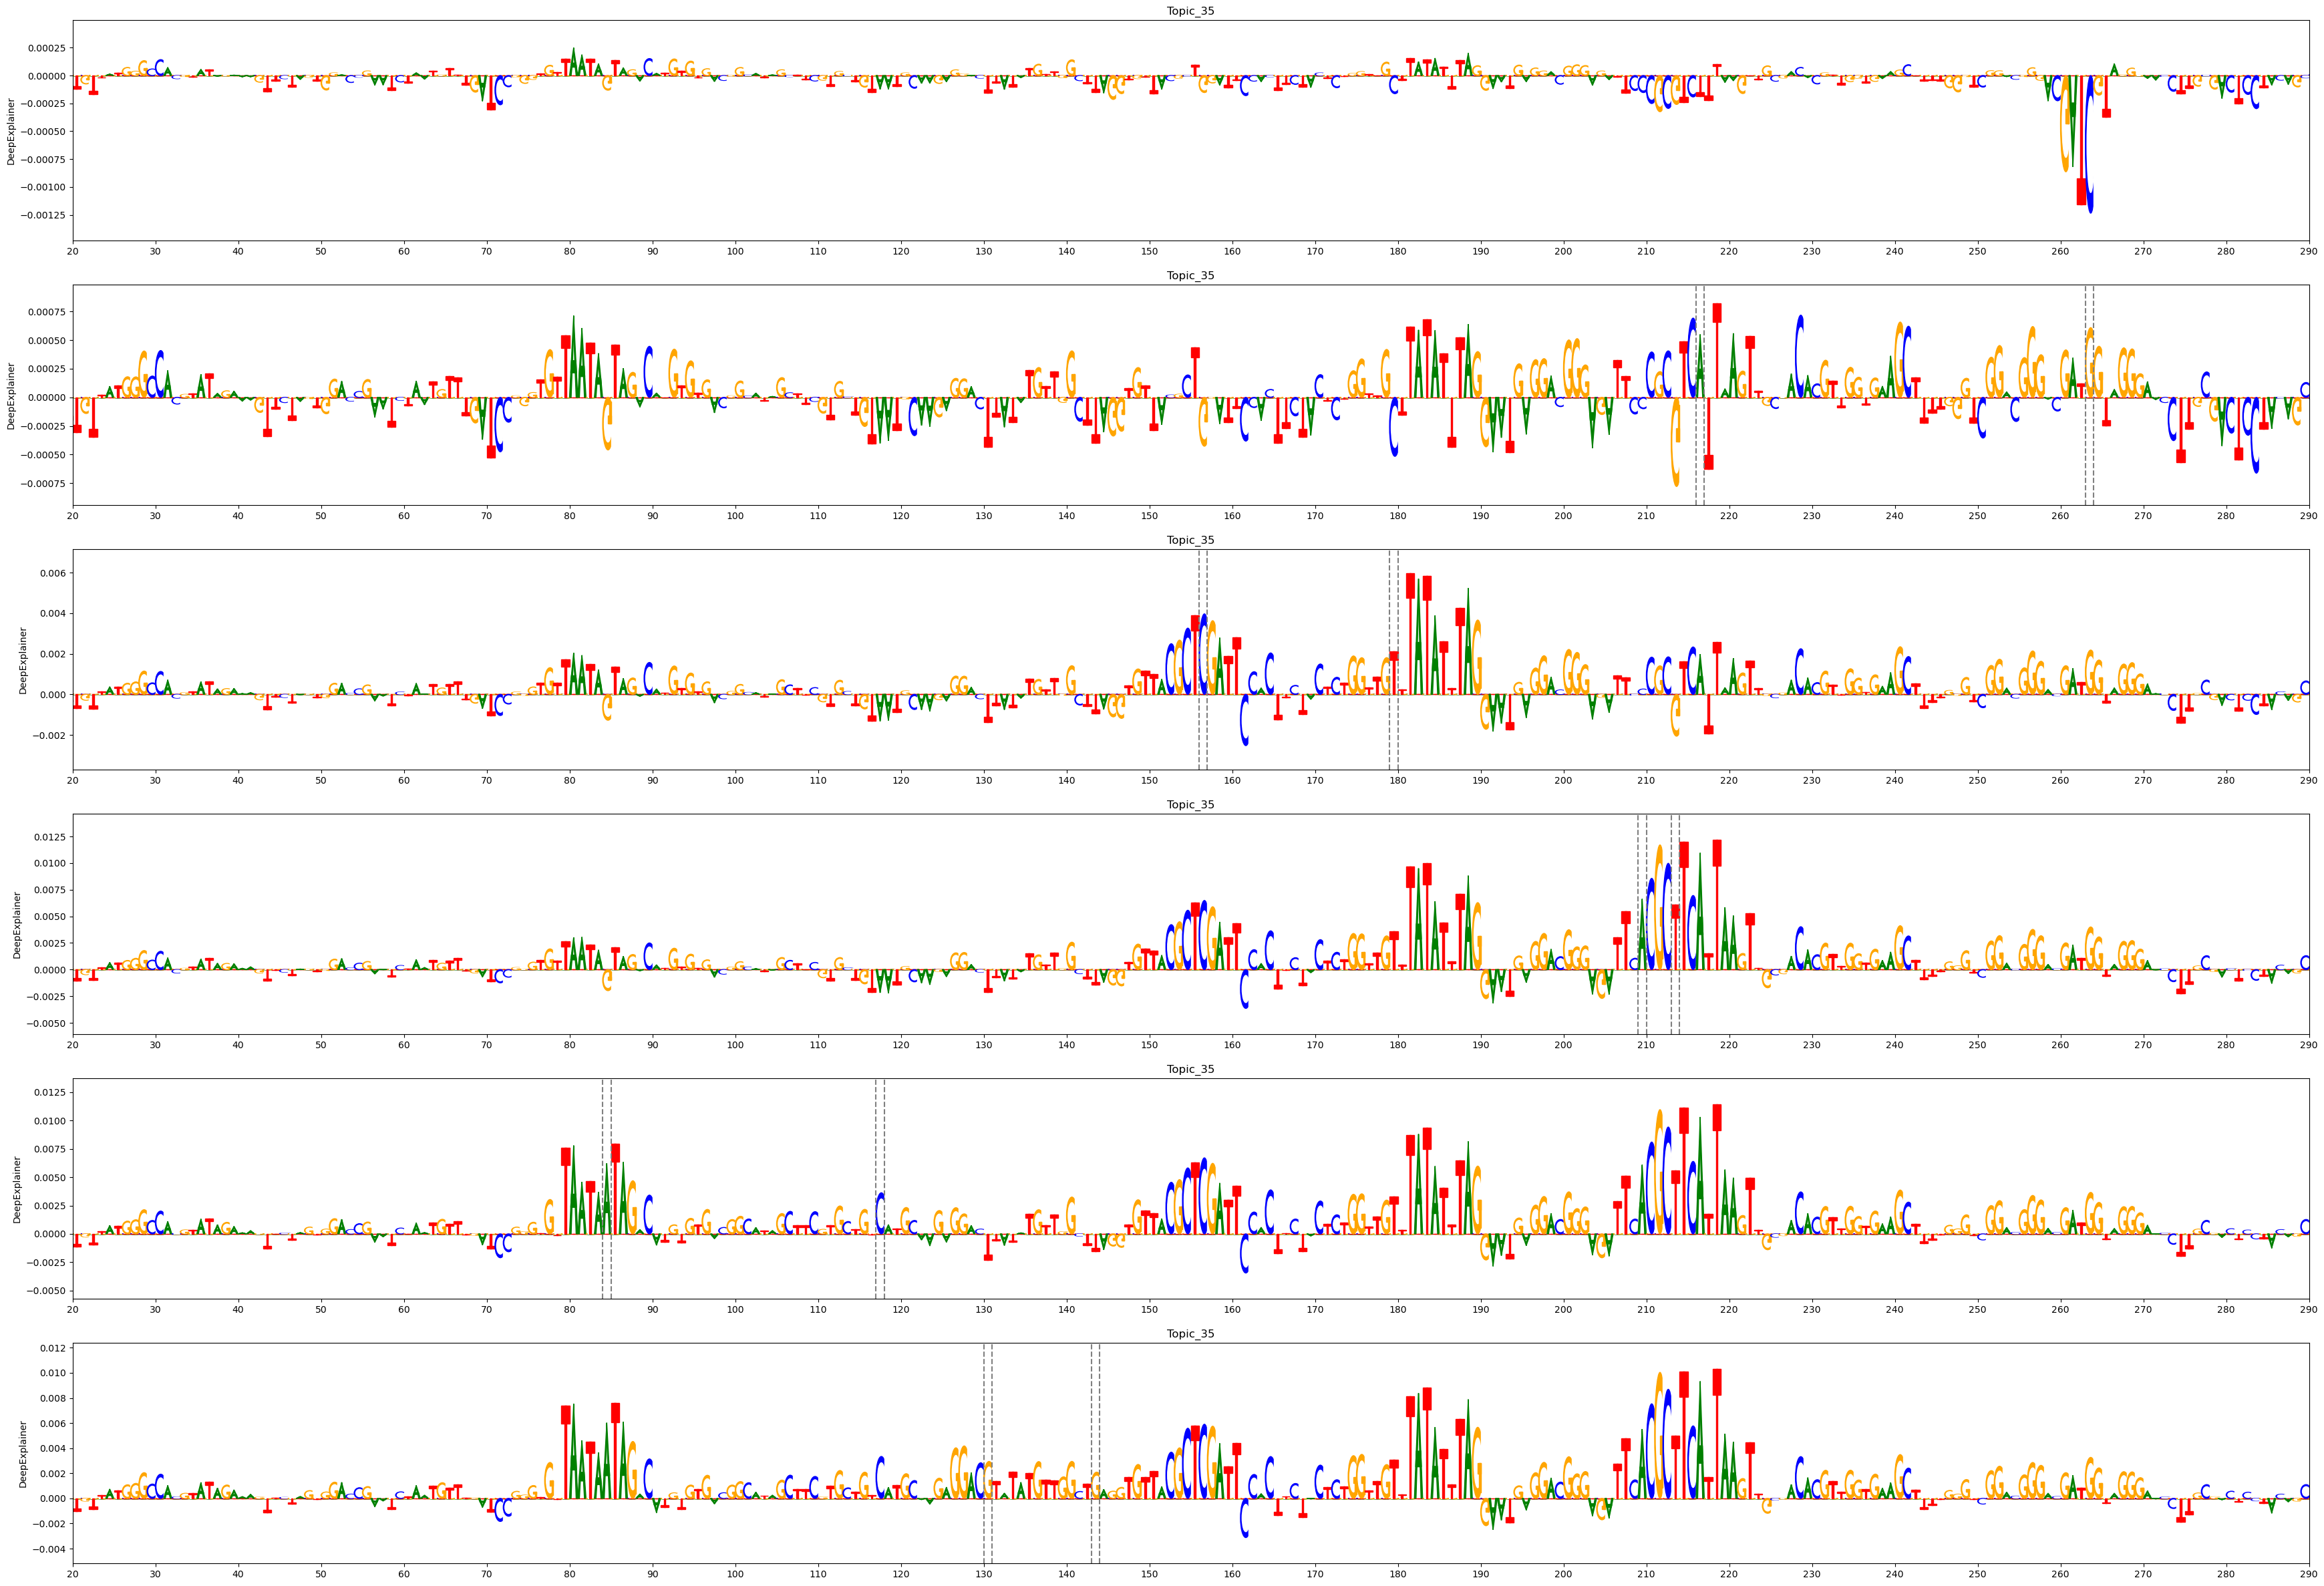

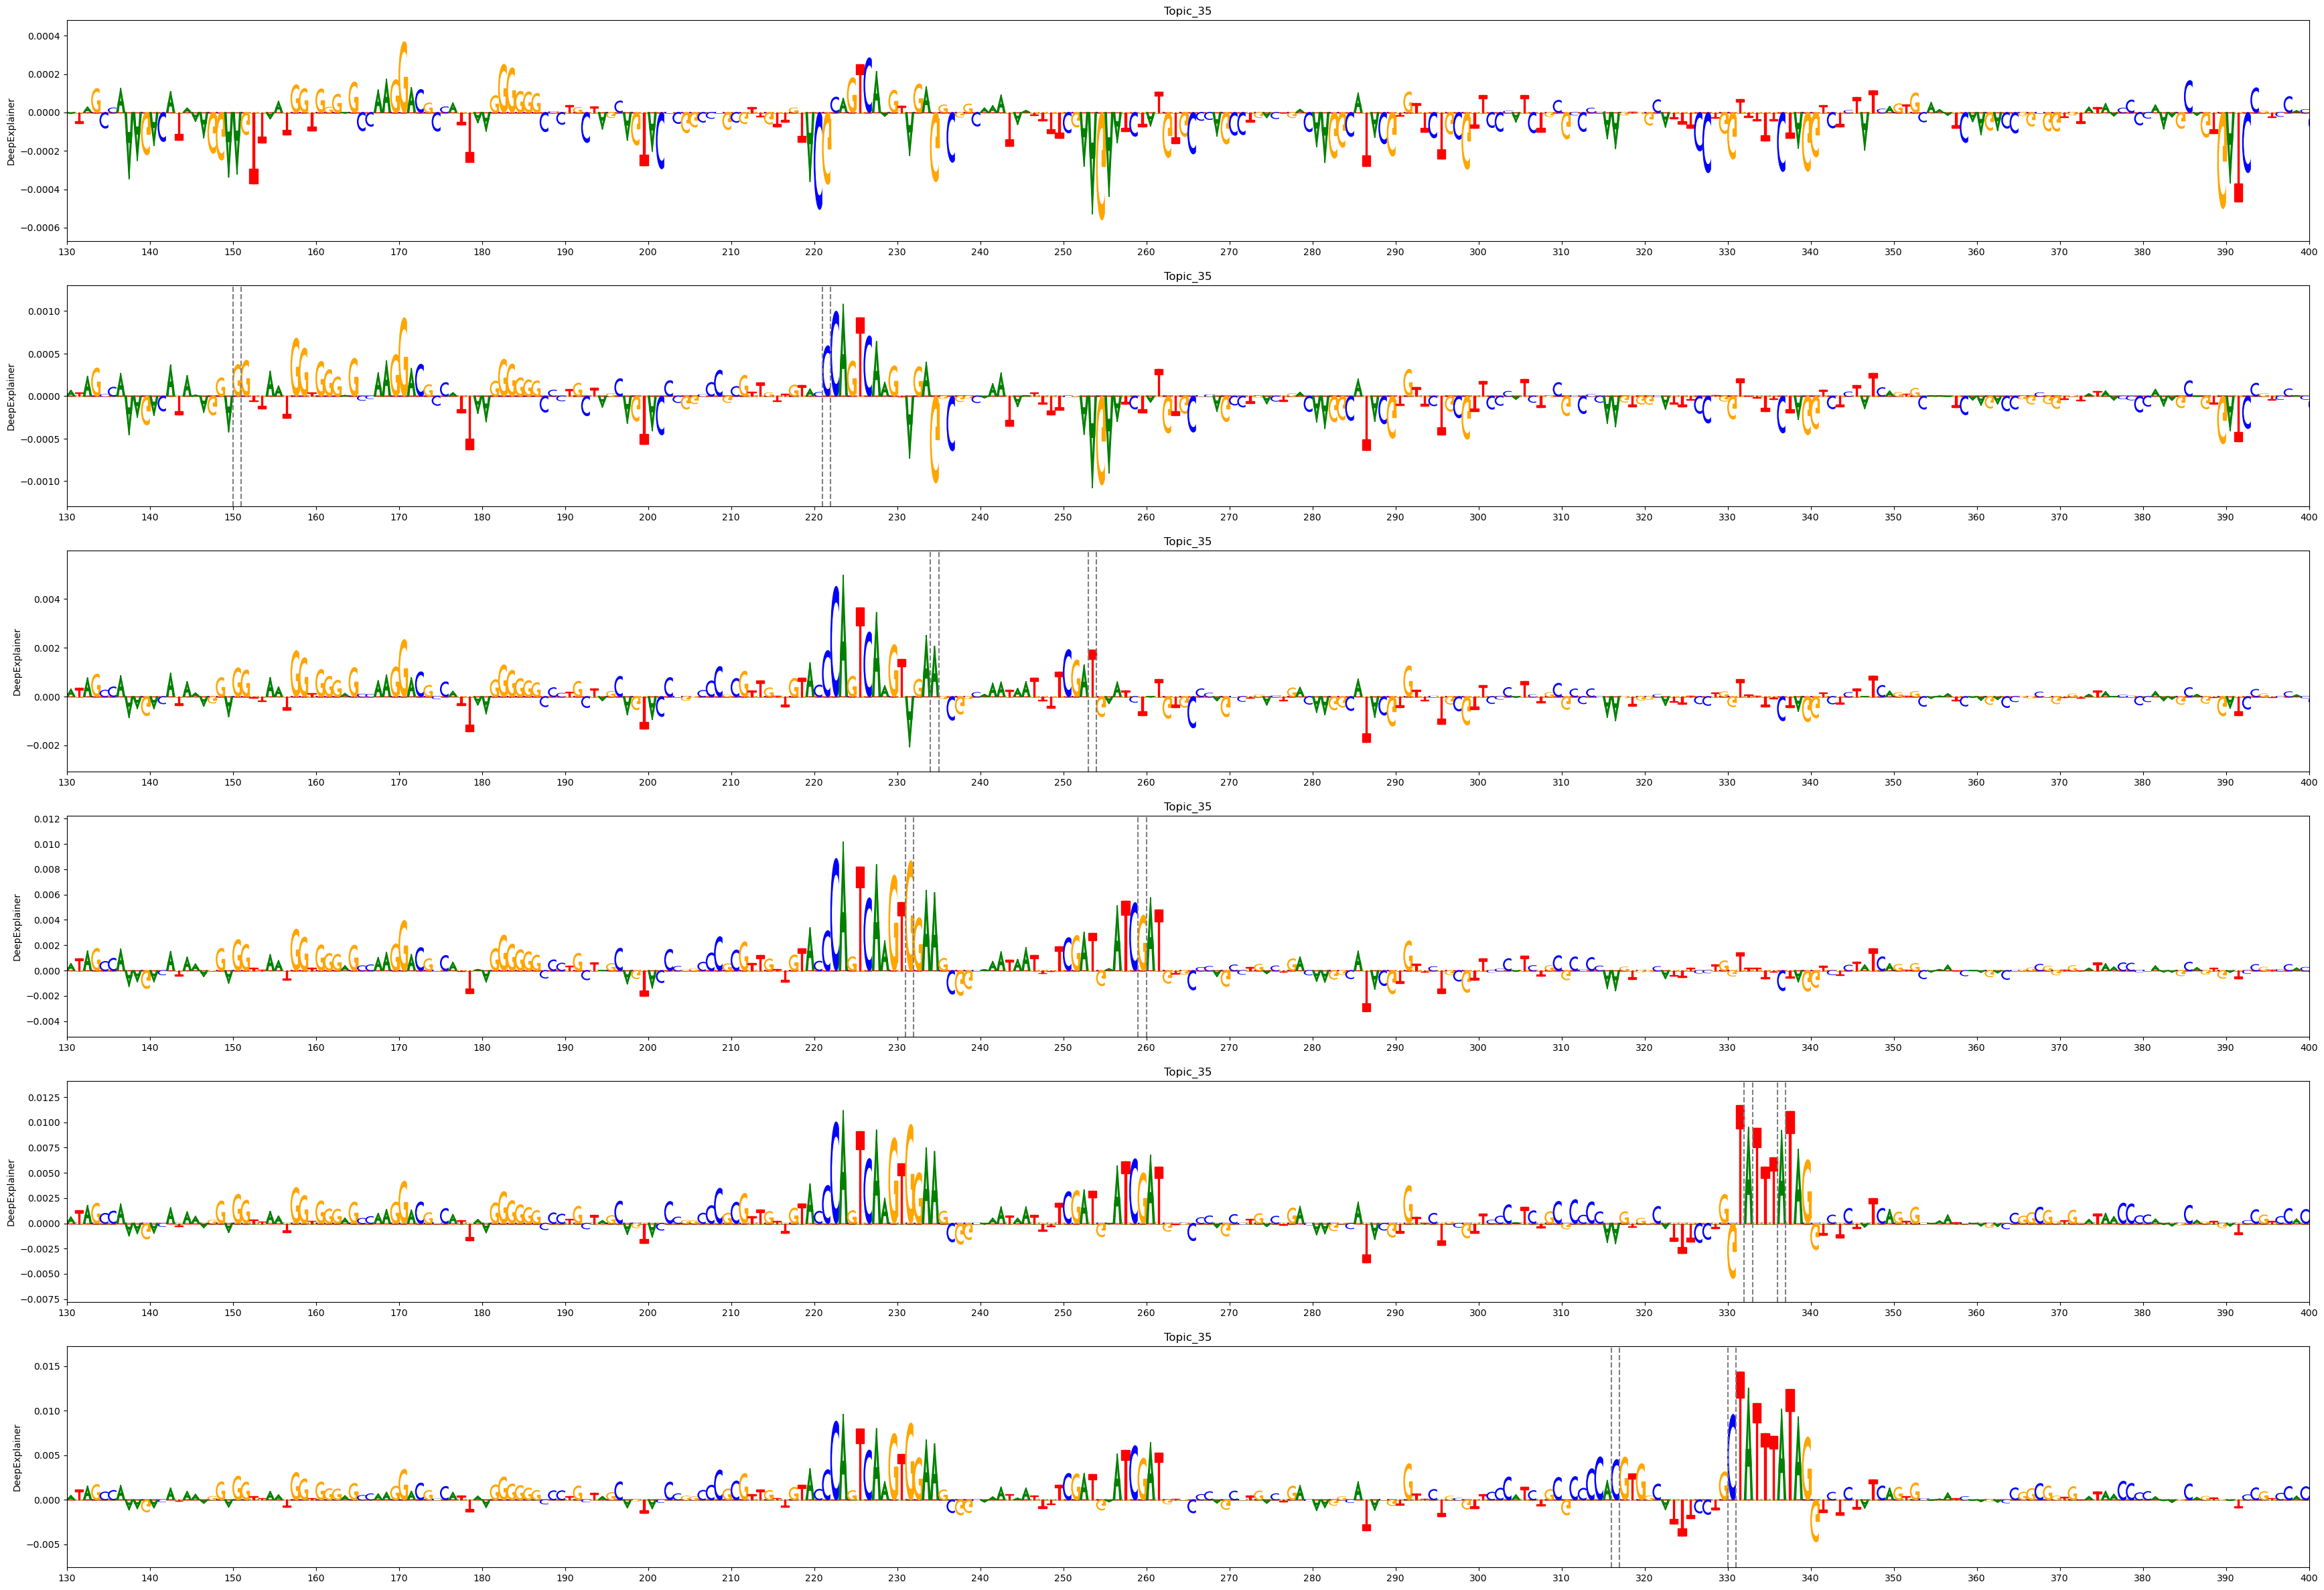

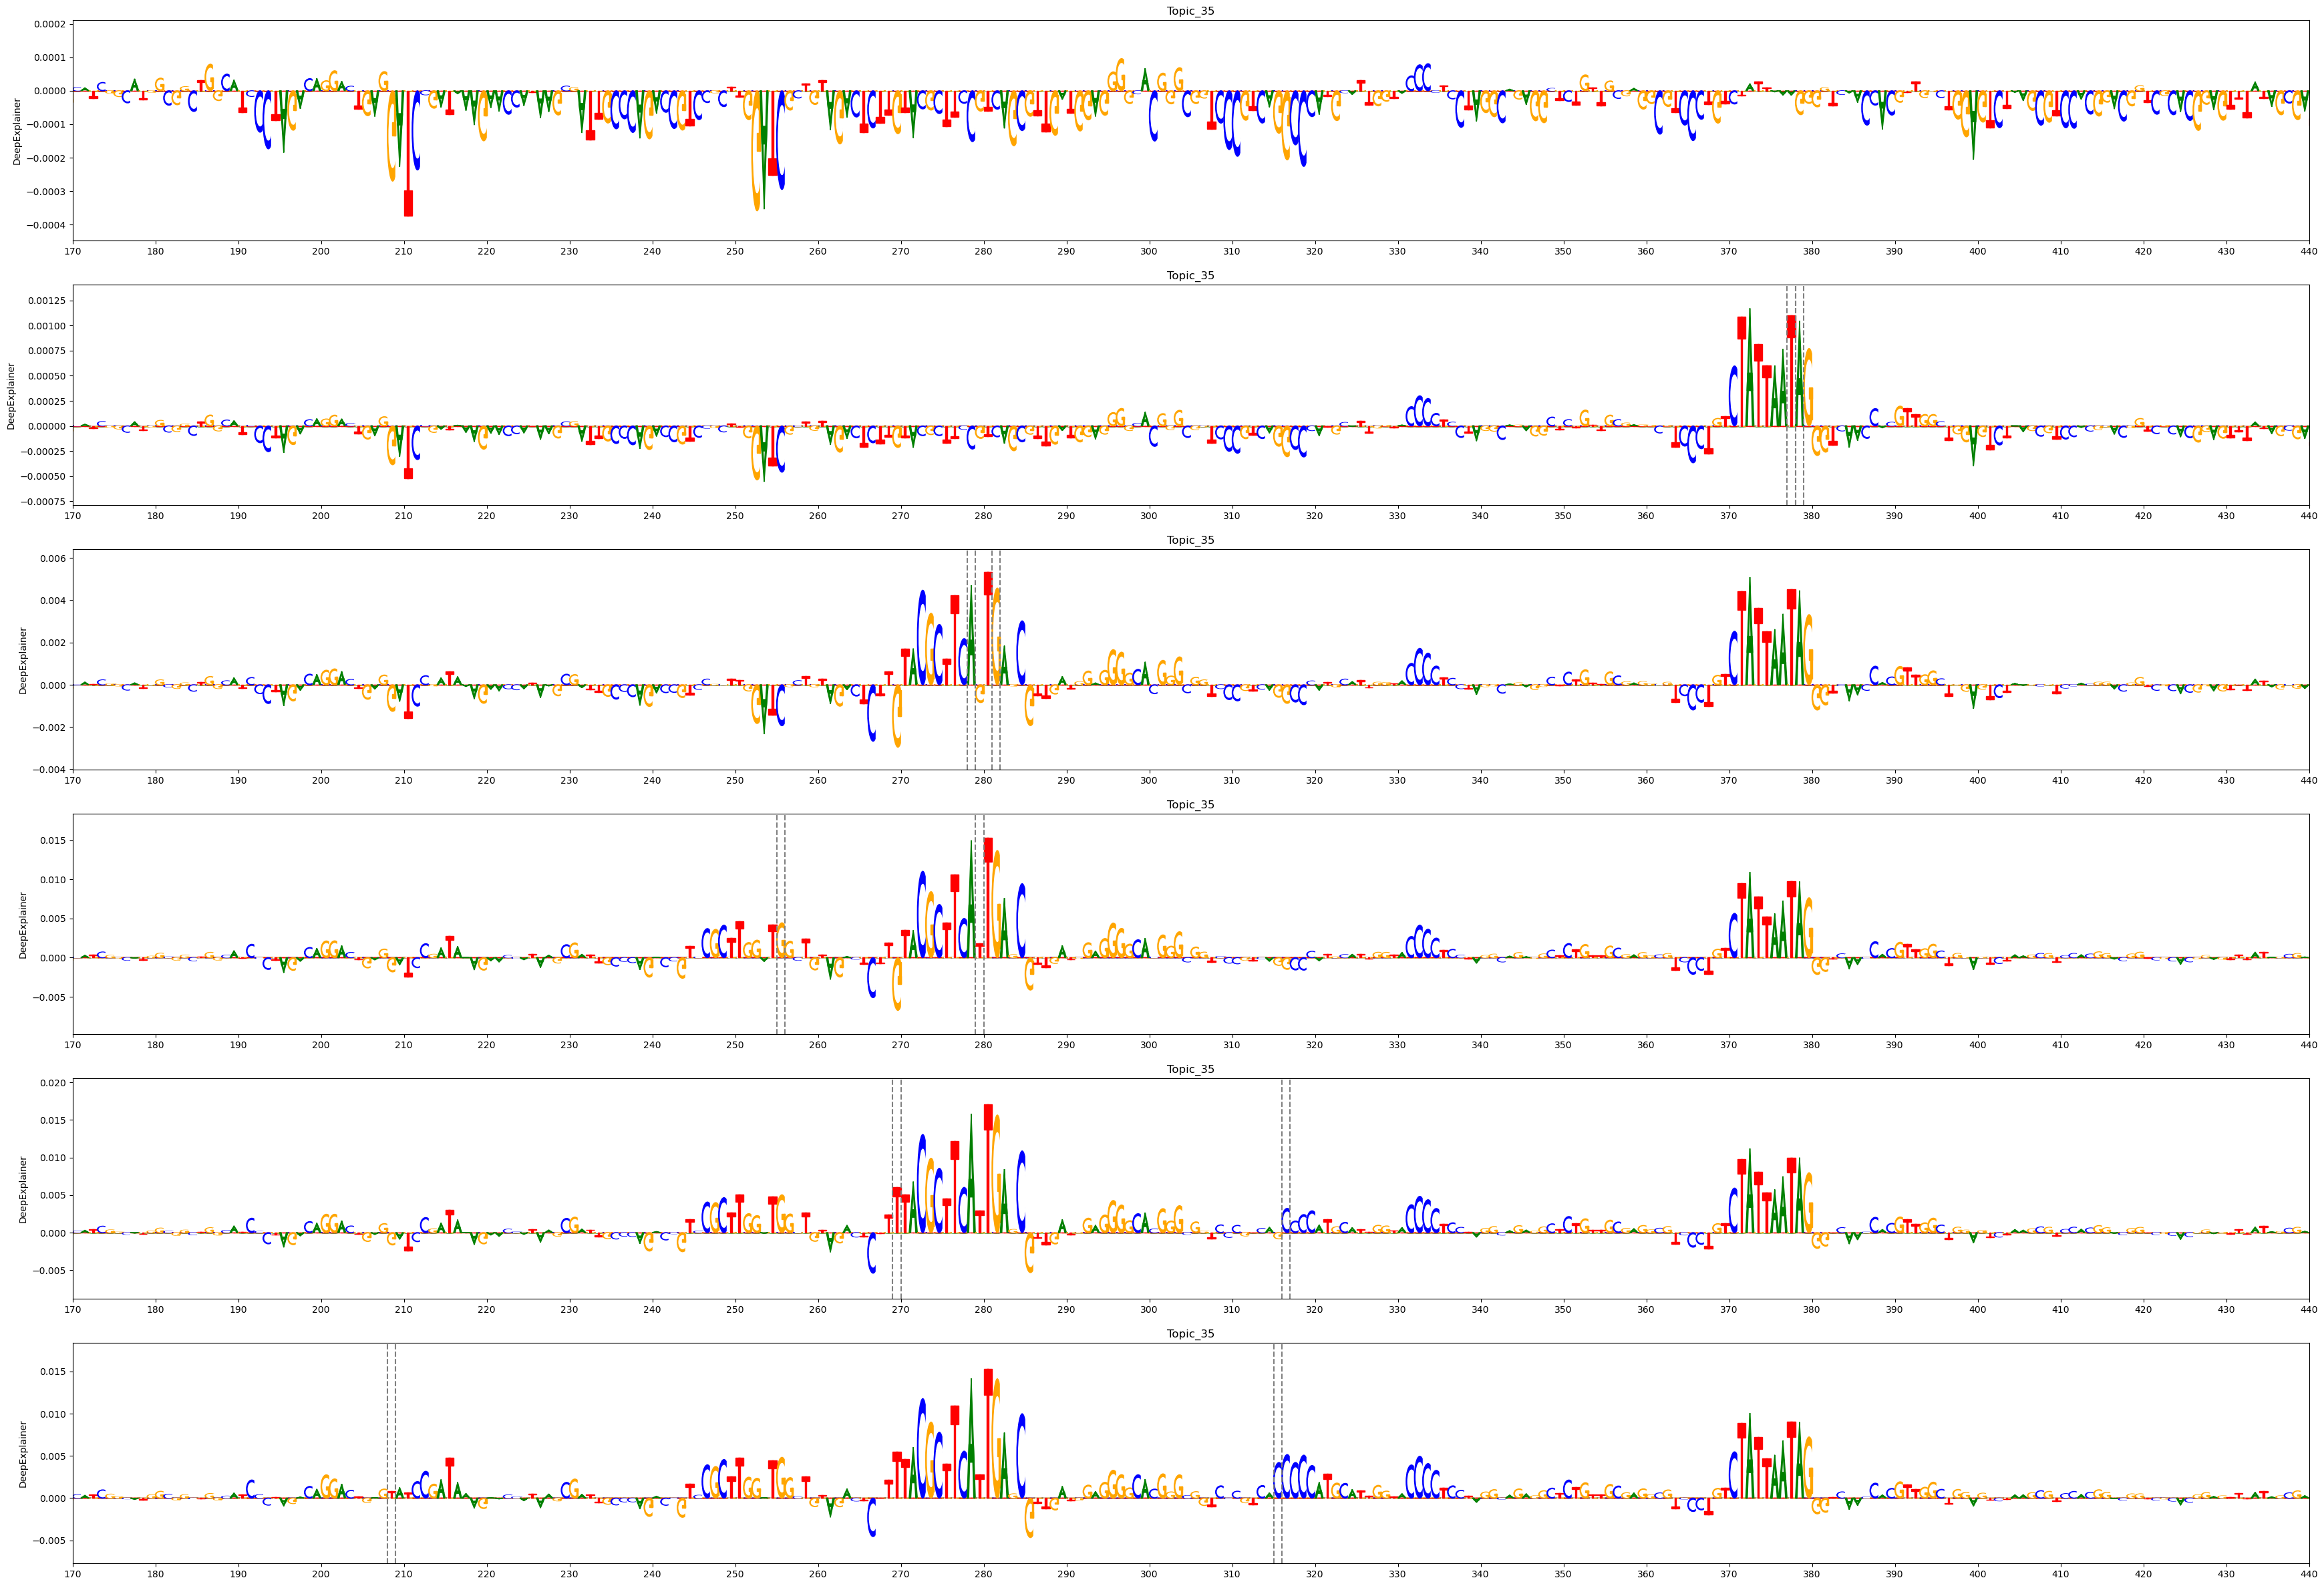

In [47]:
locs = [[20,290],
        [130,400],
        [170,440]]

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

for j, [id_, enh_] in  enumerate([[32,'3'],[35,'4'],[91,'7']]):  
    st = locs[j][0]
    end = locs[j][1]
    
    ntrack = 6
    fig = plt.figure(figsize=(43.2,ntrack*5))
    

    for track_no, mutno_ in enumerate(list(range(0,11,2))):
        start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
        for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:mutno_]):
            print(i,end=",")
            start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
        
        ax_ = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=track_no+1, seq_onehot=start_x, class_no = 35)
        ax_.set_xlim([st,end])

        for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:mutno_][-2:]):
            ax_.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
            ax_.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
        
        ax_.set_xlim([st,end])

    
    plt.savefig("figures/mutational_steps/KC_EFS_"+enh_+"_Steps_0_2_4_6_8_10M_DeepExplainer.pdf",transparent=True)


# Below, the same experiments (above) are performed for different evolved sequences

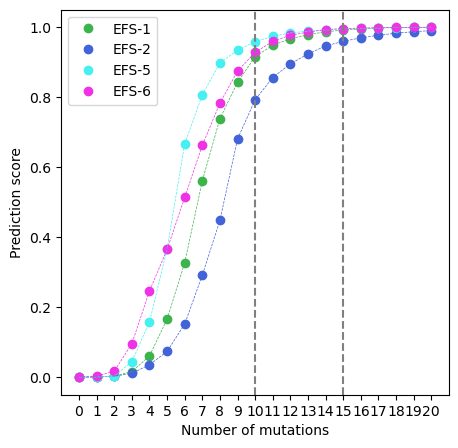

In [26]:
colors_ = ['#e6194b', '#3cb44b', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#fabebe', '#008080', '#e6beff', '#9a6324','#800000', '#000075']

plt.figure(figsize=(5,5))
class_no = 35 - 1
ids__ = [[1,'1'],[21,'2'],[59,'5'],[61,'6']]
for k,i in enumerate(ids__):
    _ = plt.plot(evolved_seq_6000_dict["mut_pred"][i[0],:21,class_no].T,label="EFS-"+i[1],linestyle="",marker="o",color=colors_[int(i[1])])
plt.legend()
for k,i in enumerate(ids__):
    _ = plt.plot(evolved_seq_6000_dict["mut_pred"][i[0],:21,class_no].T,label="EFS-"+i[1],linestyle="--",linewidth=0.5,color=colors_[int(i[1])])
_ = plt.xticks(range(21),list(range(21)))
plt.axvline(x=15,linestyle="--",color="gray")
plt.axvline(x=10,linestyle="--",color="gray")
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.savefig("figures/mutational_steps/KC_EFS_1_2_5_6_Rescue_Prediction.pdf",transparent=True)

In [29]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
for id_ in [1,21,59,61]:     
    start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
    print("id:",id_)
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:15]):
        print(mut_,end=",")
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    print("") 
    for nuc in start_x[0]:
        if nuc[0]==1:
            print("A",end="")
        if nuc[1]==1:
            print("C",end="")
        if nuc[2]==1:
            print("G",end="")
        if nuc[3]==1:
            print("T",end="")
    print("")



id: 1
83_G,48_C,64_A,118_C,139_T,145_T,146_A,227_C,171_G,163_G,194_A,114_A,271_T,132_G,205_A,
GATACACCGGTCACCGCCAGGGGAGTCGAAGAGAATTCGCTTGGAGGACCTCACTTTGCAATCGATAGAAGGTTCAACGAAGCGTATAACAACATGAGAAATTGCCATAAAAATAGCCCATGTTACTCTGGCGCTAGTCTATTAATAGCGAGTCACGTGGTGAGTTGCCACGTGCCCCCGACGGCGCTGAATCCATCAAAGCGGGAACACATTCCAACTCAGAGTGTCCTTATGTCTGGGGGTCGTGACCGCTCCTCACCTCGTCCGCGATTTAAAGGCTAGGCCCTGCCCAGTCACTATTTCGGAGGTCTCGGCTAGCCCCTAACAGTGATCTCGTTTCGACGTTCGCTCTATTACACTAGCAAAAAGAGCATTTTTACAAAAGTTTAGAGAAAAGTCCCAACCTGTTAAGAAATTAAGGCCTGAAGCTGATTTGGTAGACCGTATTAATACACTCAAGACTCTGAGGGGGTTTCATTAGTGAGGGATACCCCCTTTAT
id: 21
170_C,158_T,122_A,213_T,89_T,109_T,121_T,61_T,66_A,99_T,270_G,49_C,255_T,202_G,18_C,
GGCAGACTACTACTCTGACTCGGTCAAATACATAACATTCACGCCGTACCACACGGATGATTGACCAAGCGTGAATTAAGAAACACCCATGAACGTCCATGGCGAACGCTCTTGCGGAACTTATAAATAGAACTACGCGAAGGGATACACAGAGCAAATCGATAGGGCCCCTCTTACACTCCCTCTTAATCTGGACACAGGGGTGTAATTTAGTGAGGTGTGTTCGCCTAGGCTGAGAACGCAAGGCTGTGCCGTTAGCTTAATACTAAGGATGCCGTTGCGGTTGATATGAAAGTACCAGTACGACCCCACT

0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,

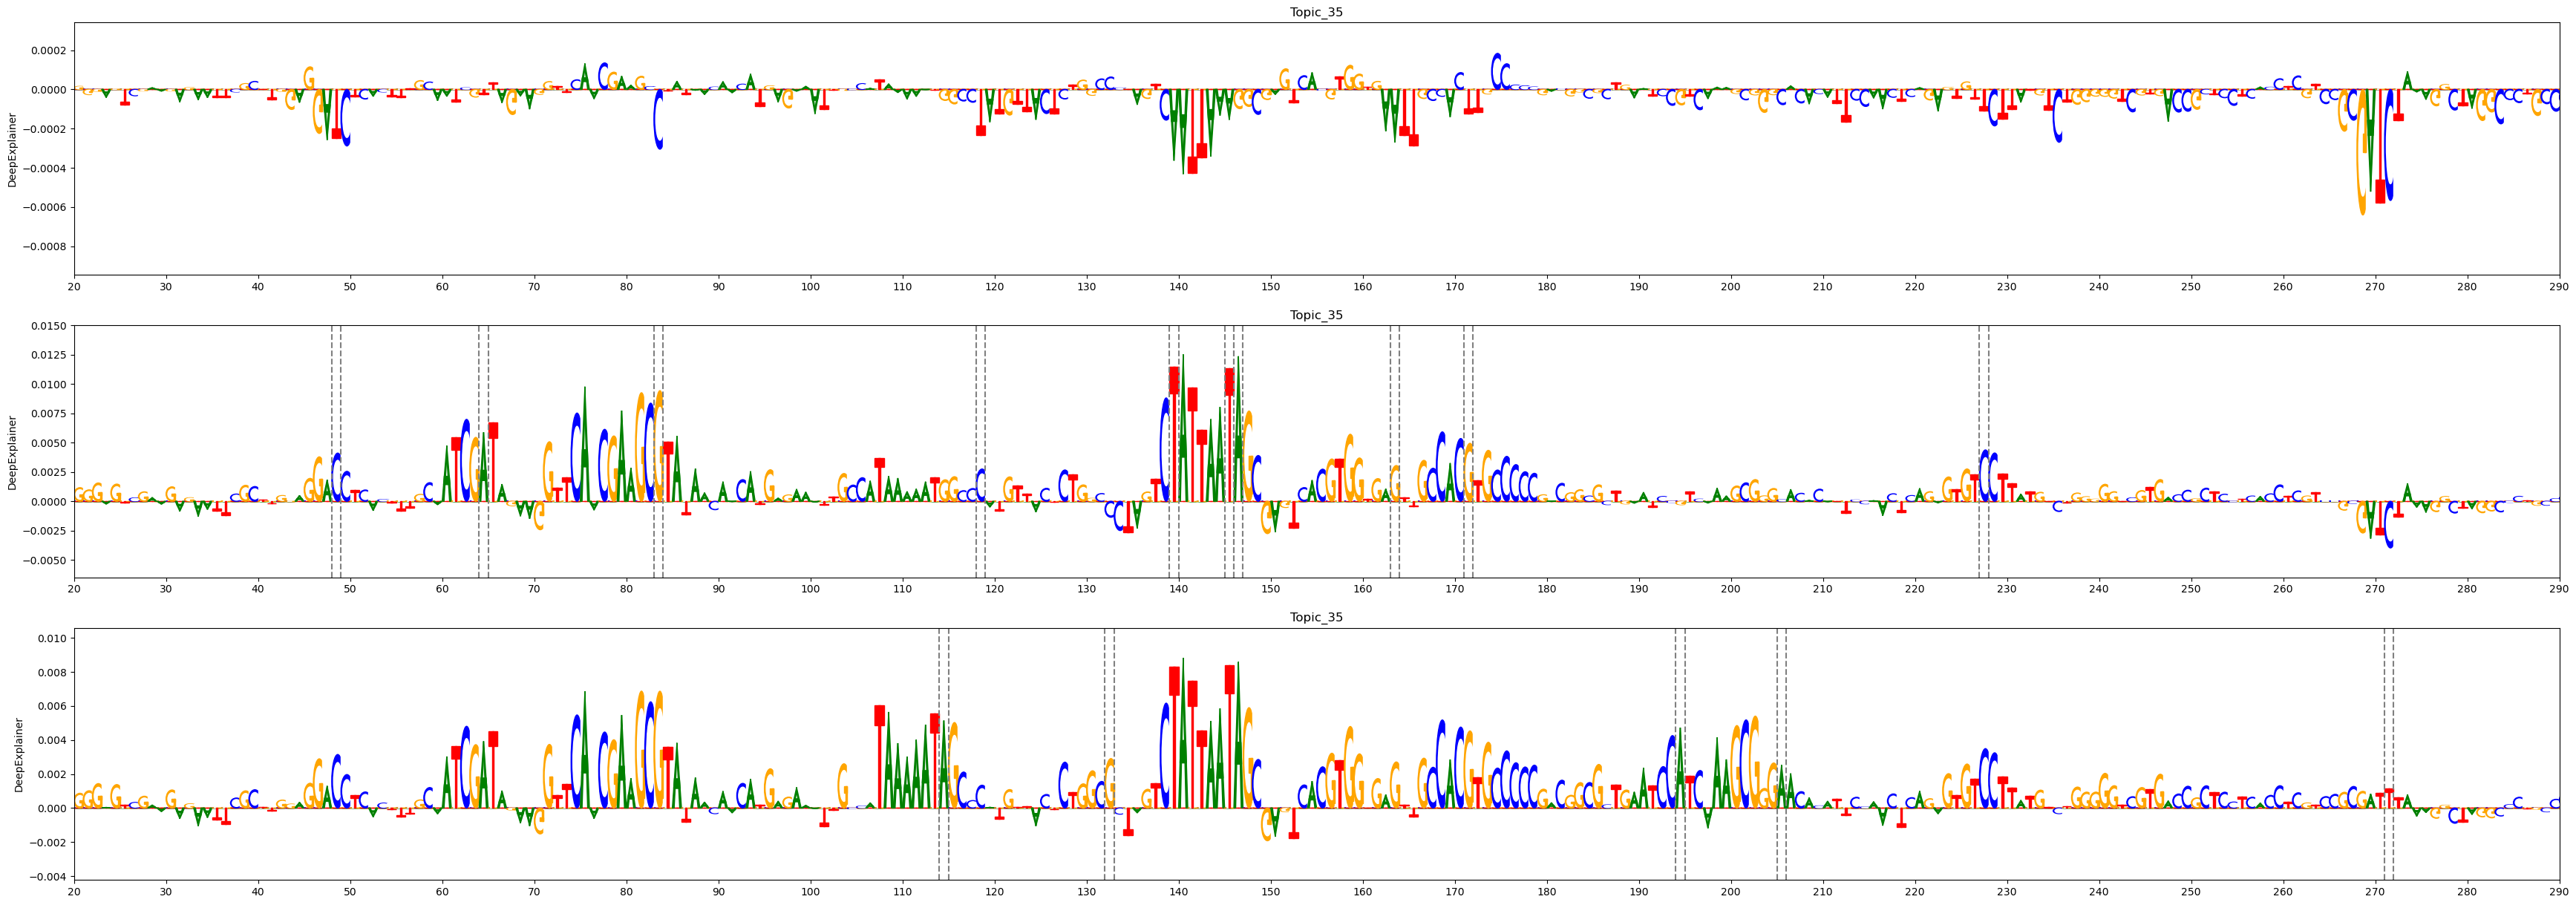

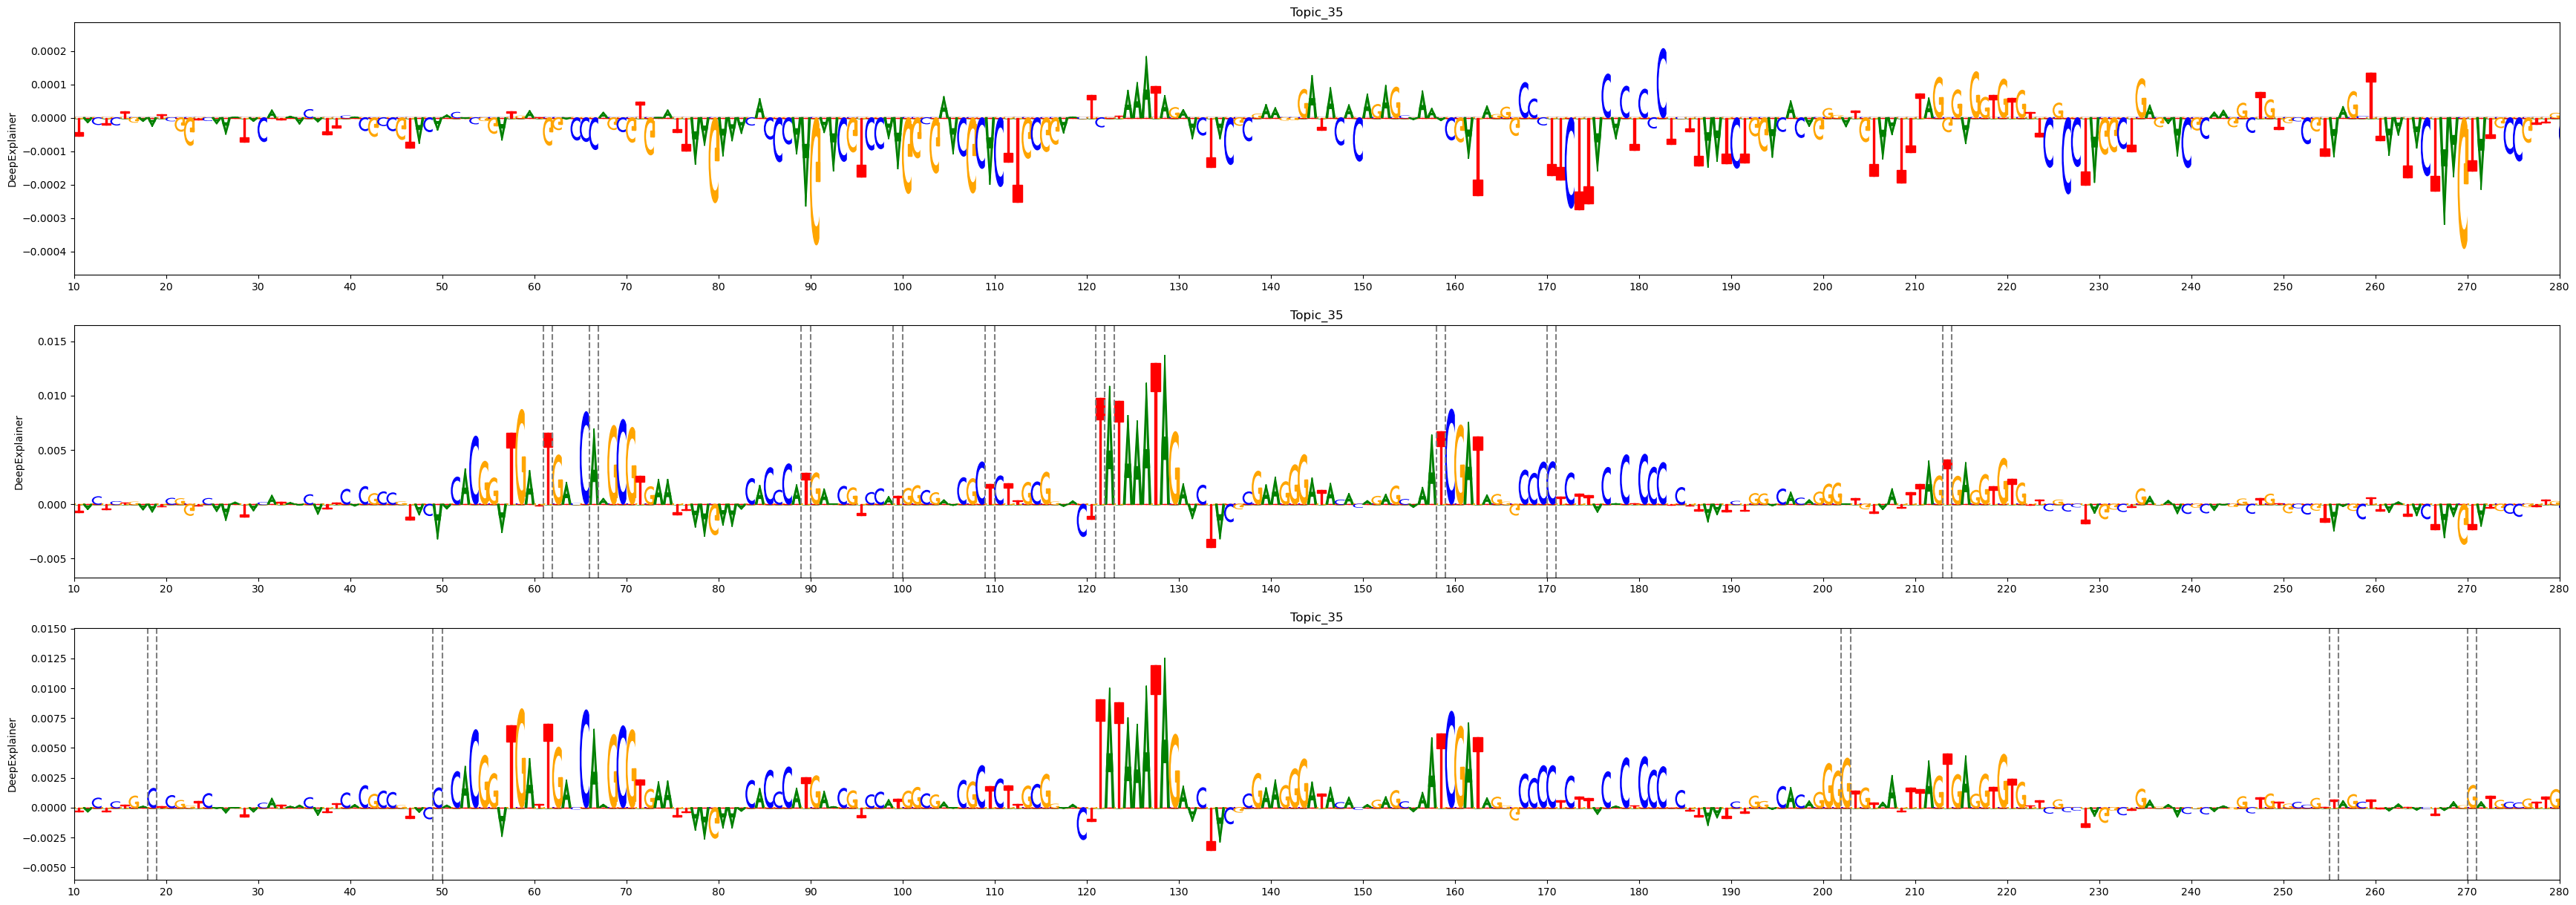

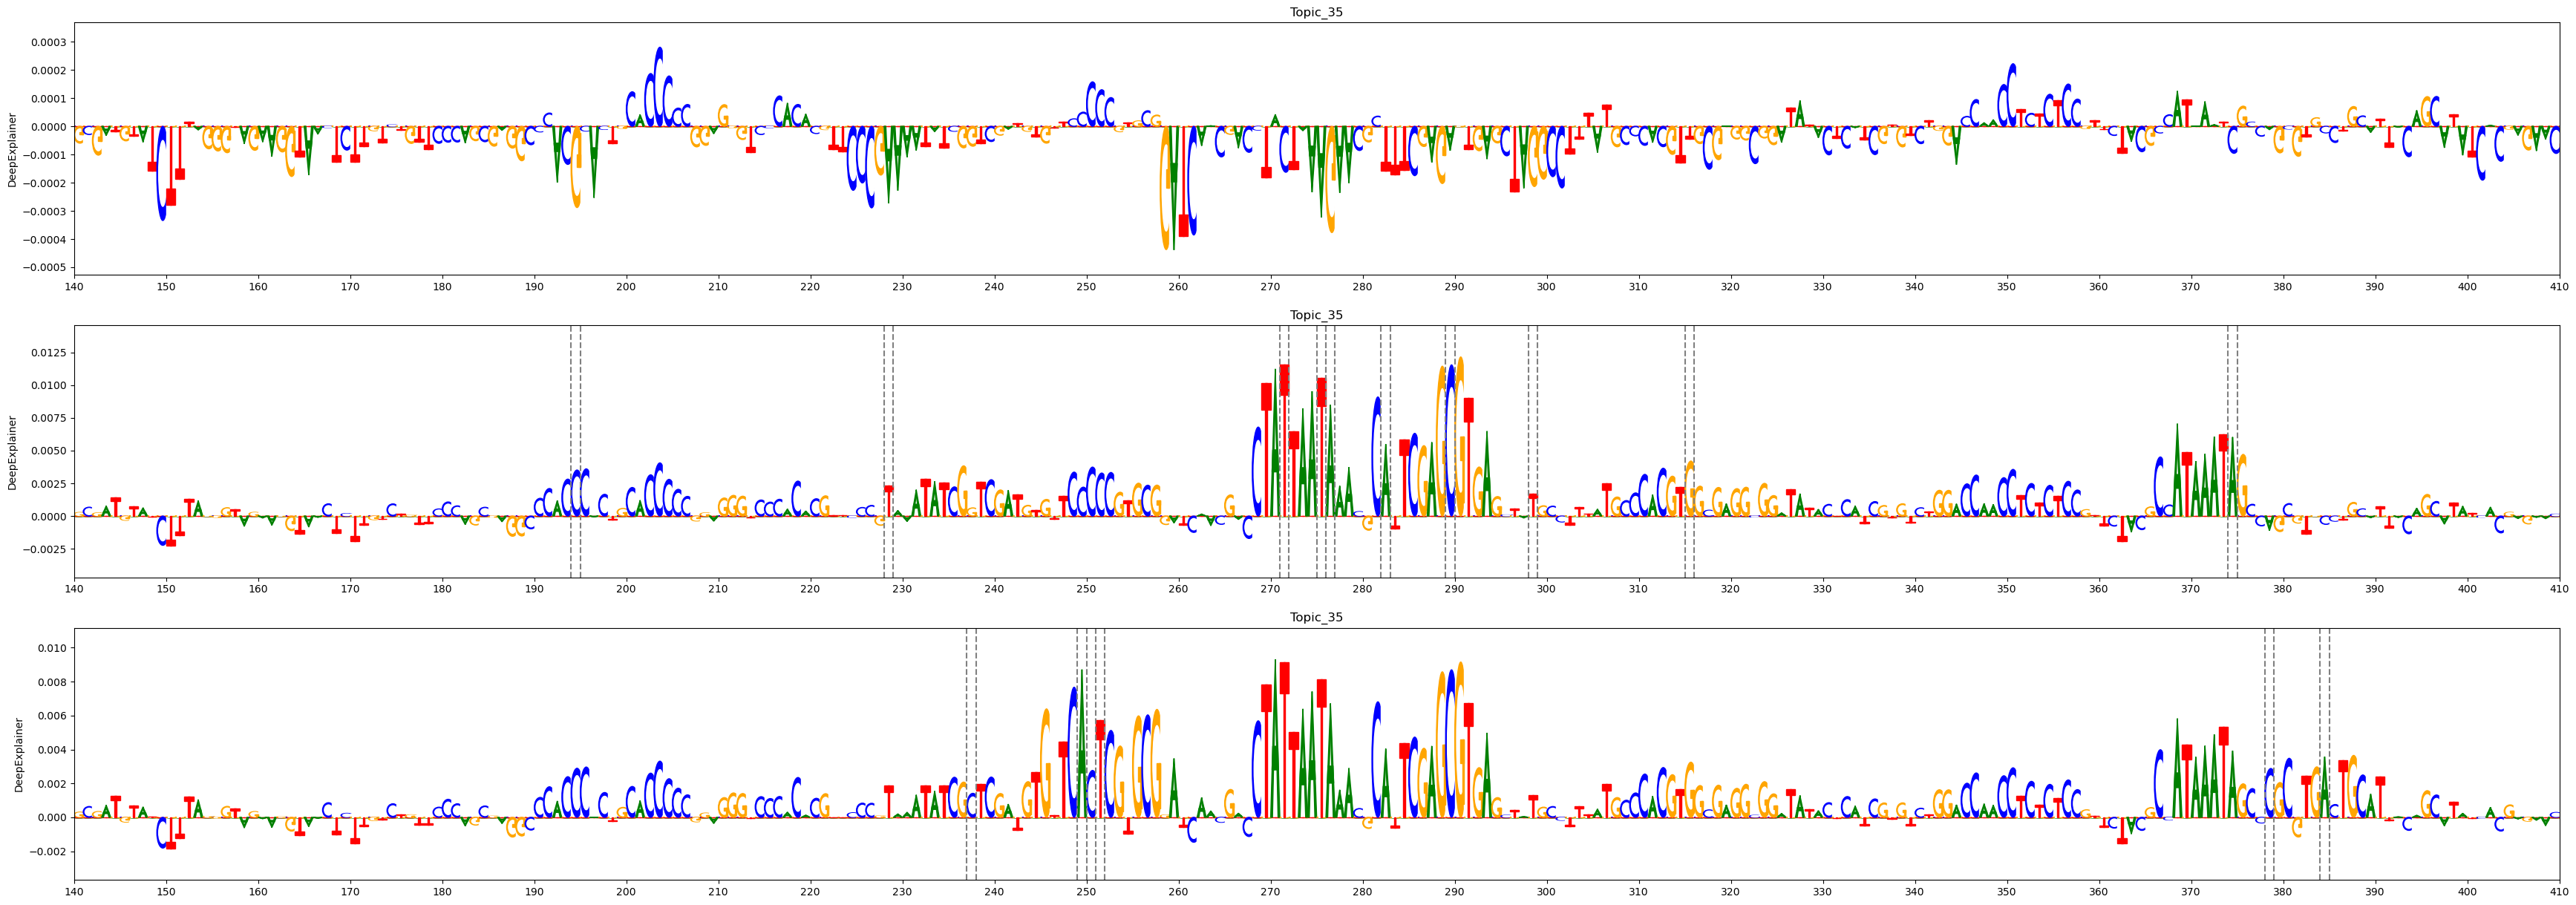

In [34]:
locs = [[20,290],
        [10,280],
        [140,410]]

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

for j, [id_, enh_] in  enumerate([[1,'1'],[21,'2'],[59,'5']]):  
    st = locs[j][0]
    end = locs[j][1]
    
    ntrack = 3
    fig = plt.figure(figsize=(43.2,ntrack*5))
    start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
    ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)

    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:10]):
        print(i,end=",")
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:15]):
        print(i,end=",")
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:10]):
        ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
        ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][10:15]):
        ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
        ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

    ax1.set_xlim([st,end])
    ax2.set_xlim([st,end])
    ax3.set_xlim([st,end])
    
    plt.savefig("figures/rescue/KC_EFS_"+enh_+"_Rescue_0_10_15M_DeepExplainer.pdf",transparent=True)


0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,

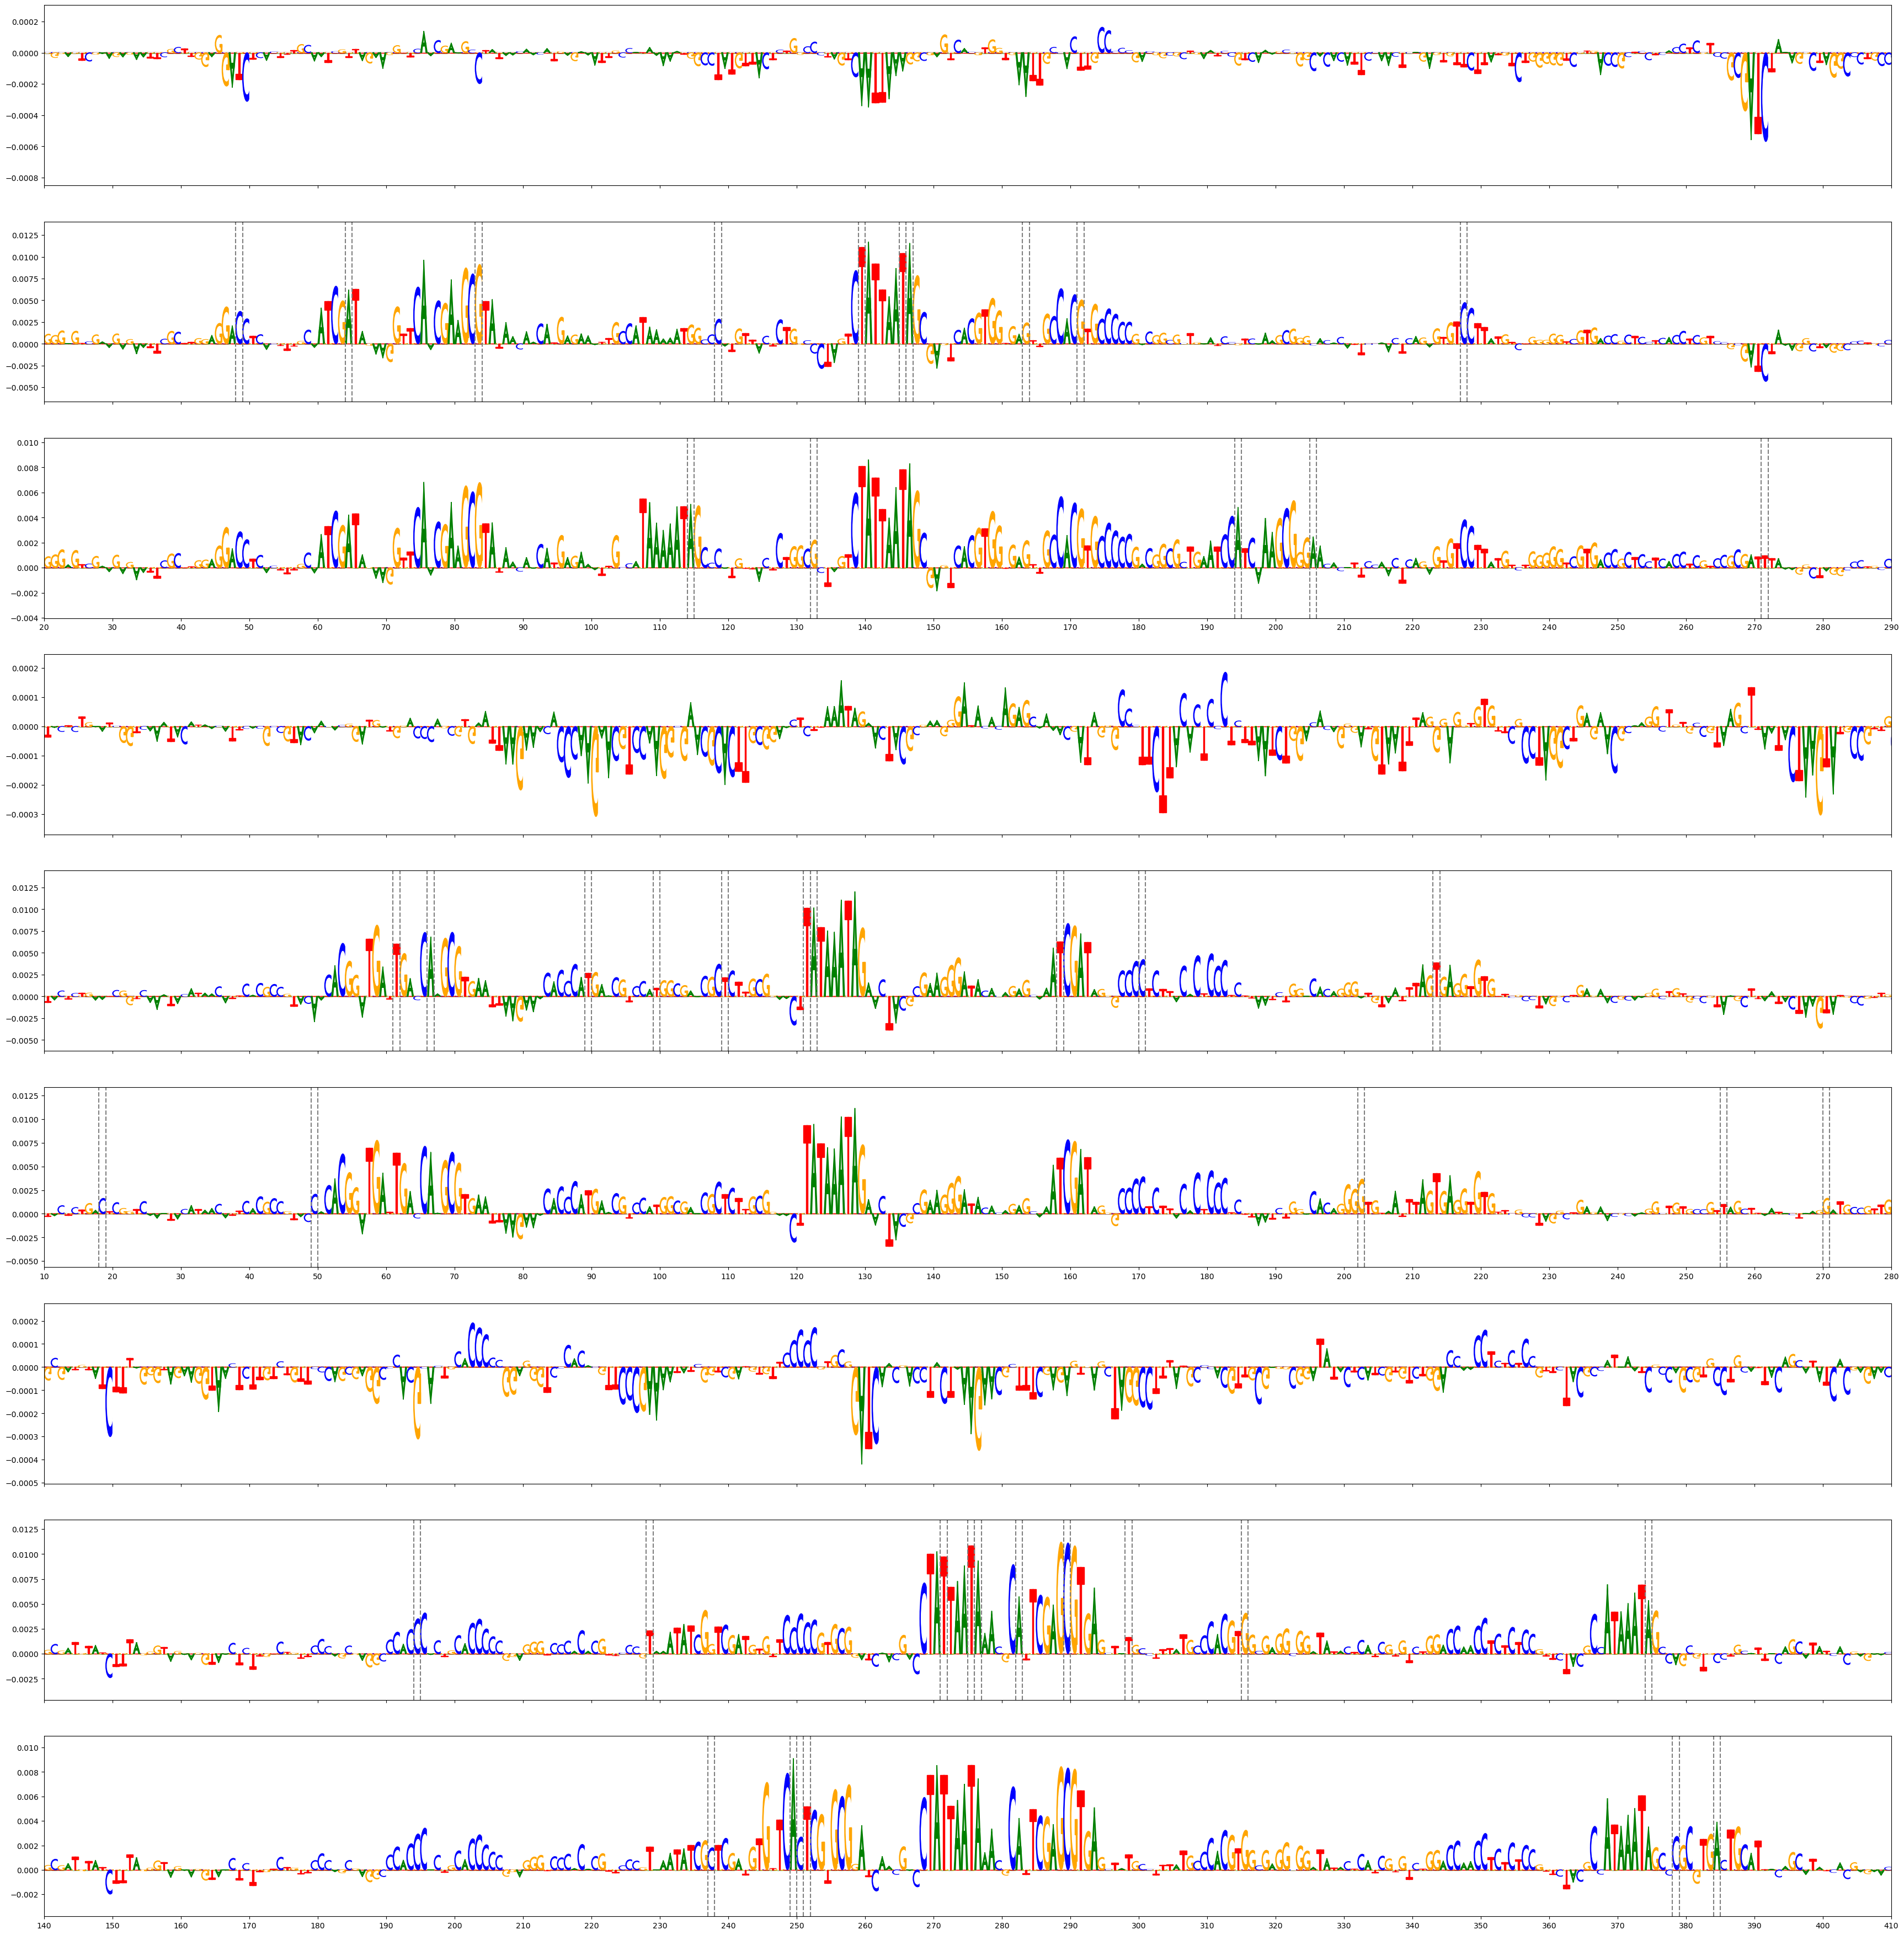

In [6]:
locs = [[20,290],
        [10,280],
        [140,410]]

ntrack = 9
fig = plt.figure(figsize=(43.2,ntrack*5))

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

for j, [id_, enh_] in  enumerate([[1,'1'],[21,'2'],[59,'5']]):  
    st = locs[j][0]
    end = locs[j][1]
    
    
    start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
    ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=j*3+1, seq_onehot=start_x, class_no = 35)

    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:10]):
        print(i,end=",")
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=j*3+2, seq_onehot=start_x, class_no = 35)
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:15]):
        print(i,end=",")
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=j*3+3, seq_onehot=start_x, class_no = 35)
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:10]):
        ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
        ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][10:15]):
        ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
        ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

    ax1.set_xlim([st,end])
    ax2.set_xlim([st,end])
    ax3.set_xlim([st,end])
    ax1.set_title("")
    ax1.set_ylabel("")
    ax2.set_title("")
    ax2.set_ylabel("")
    ax3.set_title("")
    ax3.set_ylabel("")
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    
plt.savefig("figures/rescue/KC_EFS_Rescue_all_DeepExplainer.pdf",transparent=True)


0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,

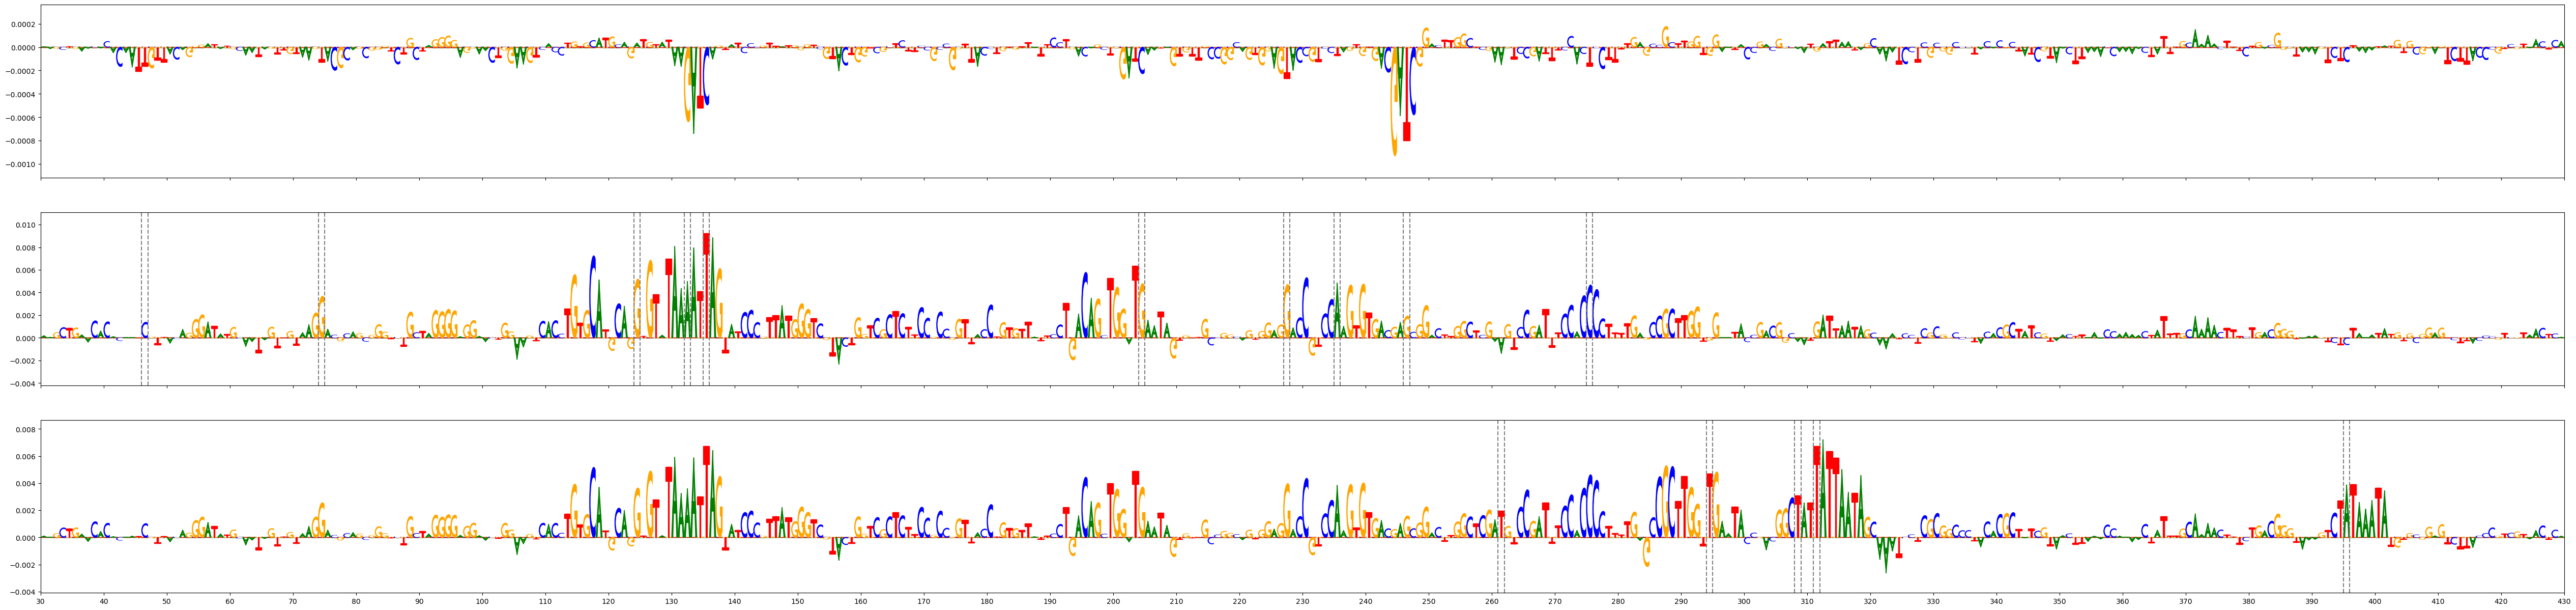

In [7]:
locs = [[30,430]]

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

for j, [id_, enh_] in  enumerate([[61,'6']]):  
    st = locs[j][0]
    end = locs[j][1]
    
    ntrack = 3
    fig = plt.figure(figsize=(64,ntrack*5))
    start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
    ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)

    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:10]):
        print(i,end=",")
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:15]):
        print(i,end=",")
        start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:10]):
        ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
        ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    
    for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][10:15]):
        ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
        ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

    ax1.set_xlim([st,end])
    ax2.set_xlim([st,end])
    ax3.set_xlim([st,end])
    
    ax1.set_title("")
    ax1.set_ylabel("")
    ax2.set_title("")
    ax2.set_ylabel("")
    ax3.set_title("")
    ax3.set_ylabel("")
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    
    plt.savefig("figures/rescue/KC_EFS_"+enh_+"_Rescue_0_10_15M_DeepExplainer.pdf",transparent=True)
